2017 Edition

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [91]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: {}s".format(time.time() - time_start))
print(words.take(5))

Runtime: 339.69973492622375s
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [1]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc

In [93]:
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: {}s".format(time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 197.82173490524292s


After having executed the code related to the two different approaches, RDD and DataFrame API, it has been shown that the runtime of the code that uses RDD was '339.69', whereas the runtime needed by the code that uses DataFrame API was '197.82'. 
The DataFrame API approach is much faster because RDDs don’t perform particularly well whenever Spark needs to distribute the data within the cluster, or write the data to disk, since it uses the Java serialization mechanism by default. There is a big overhead during the serialization because it requires sending both data and structure between nodes (each serialized object contains the class structure as well as the values). There is also the overhead of garbage collection that results from creating and destroying individual objects.
On the contrary the DataFrame API introduces the concept of a schema to describe the data, allowing Spark to manage the schema and only pass data between nodes, in a much more efficient way than using Java serialization. There are also advantages when performing computations in a single process as Spark can serialize the data into off-heap storage in a binary format and then perform many transformations directly on this off-heap memory, avoiding the garbage-collection costs associated with constructing individual objects for each row in the data set. Moreover SparkSQL performs some intermediate optimizations before actually executing the code.

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD. Please note that, package com.databricks.spark.csv can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [3]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that CRSDepTime to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [4]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [5]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [6]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [126]:
night_flights = df[df.scheduled_departure_time > 1800].count()
print('Number of night flights in our data: ', night_flights)

Number of night flights in our data:  1078203


In [127]:
print('Night flights per carrier:')
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).show()

Night flights per carrier:
+-------+------+
|carrier| count|
+-------+------+
|     DL|208224|
|     US|170397|
|     AA|142832|
|     WN|124024|
|     UA|113640|
|     NW|100453|
|     CO| 94501|
|     TW| 54771|
|     HP| 44351|
|     AS| 25010|
+-------+------+



# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [128]:
src_air = df.select('src_airport').distinct().count()
dest_air = df.select('dest_airport').distinct().count()
print("Origin Airports: ", src_air)
print("Destination Airports: ", dest_air)

Origin Airports:  224
Destination Airports:  225


There is a discrepancy between the number of origin airports and the number of destination airports. We would expect those two values to be the same but they are not. This may be due to missing data. 

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [129]:
un_carr = df.select('carrier').distinct().count()
print("Unique Carriers: ", un_carr)

Unique Carriers:  10


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [130]:
night_fl = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()
print("Night Flights: ", night_fl)
tot = df.count()
print("Night Flights over Total: ", (night_fl/tot)*100, "%")

Night Flights:  1121918
Night Flights over Total:  21.658447952605844 %


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


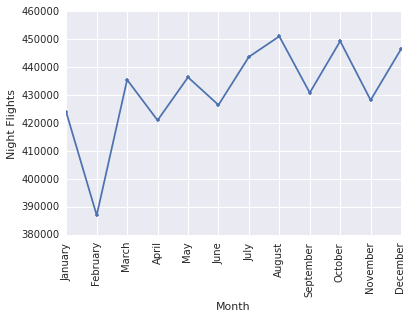

In [131]:
import datetime as dt

months = []
for month in range(1, 13):
    months.append(dt.datetime(year=1994, month=month, day=1).strftime("%B"))

fl_per_month = df.groupBy('month').count().orderBy('month').select('count').collect()
plt.xlabel('Month')
plt.ylabel('Night Flights')
plt.xticks(range(1,13), months, rotation='vertical')
plt.plot(range(1,13), np.array(fl_per_month), '.-')
plt.show()

From the plot we can see that in February we have the lowest flight traffic amount, while in August we have the hightest one. In fact, another relevant information shown by the above plot is that in holiday periods (Summer holidays in the months of July and August and Christmas holidays in December) the flight amount is much bigger with respect to other months, especially those following a holiday period.

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

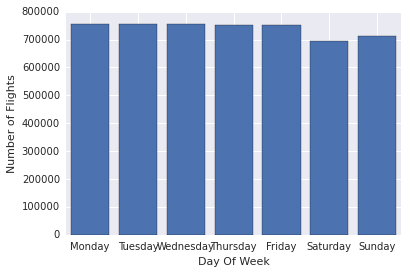

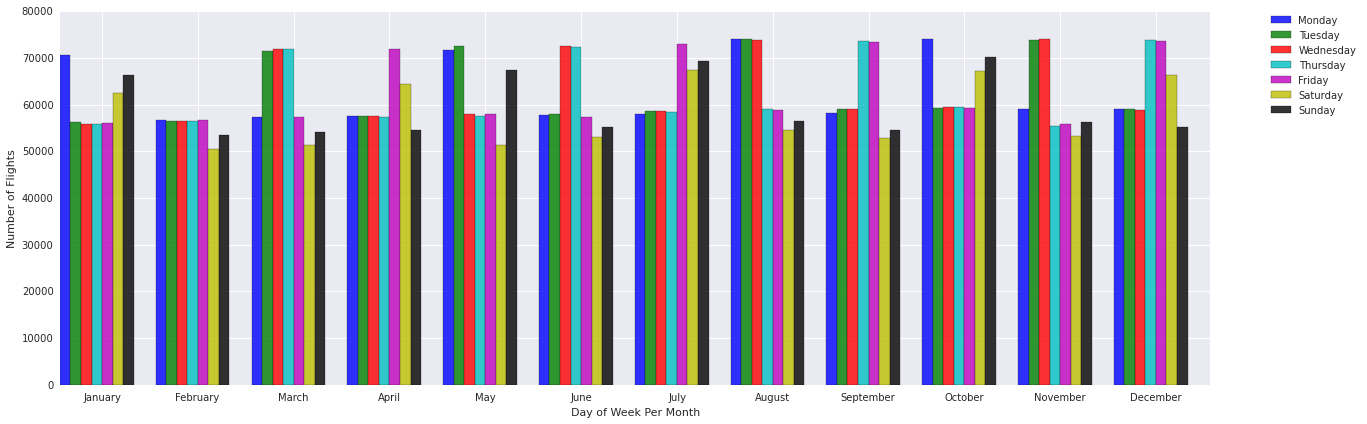

In [132]:
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fl_per_dayOfWeek = df.groupBy('day_of_week').count().orderBy('day_of_week').select('count').collect()
plt.xlabel('Day Of Week')
plt.ylabel('Number of Flights')
plt.xlim(0.5, 7.5)
plt.bar(range(1,8), np.array(fl_per_dayOfWeek), align='center')
plt.xticks(range(1,8), labels)
plt.show()

fl_per_dayOfWeek_global = df.groupBy(['month', 'day_of_week']).count().orderBy(['month', 'day_of_week'])

# data to plot
n_groups = 12

# create plot
plt.figure(figsize=(17, 6)) 
index = np.arange(0, n_groups * 5, 5)
bar_width = 0.55
opacity = 0.8

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
days_data = []
for i in range(0, 7):
    days_data.append(np.array(fl_per_dayOfWeek_global[fl_per_dayOfWeek_global.day_of_week == (i+1)].select('count').collect()))
    
for i in range(0, 7):
    plt.bar(index + bar_width*i, days_data[i], align='edge', width=bar_width, 
                 alpha=opacity,
                 color=colors[i],
                 label=labels[i])
    
plt.xlabel('Day of Week Per Month')
plt.ylabel('Number of Flights')
plt.xticks(index + bar_width*4, ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
 
plt.tight_layout()
plt.show()

The first plot shows the number of flights per day of the week in the year 1994. As we may expect the number of flights in the weekend days is slightly lower since not all the flight operators may be available in those days. We were also expecting this because flight carriers usually have lower priced tickets during the week and people flying for job releated reasons usually do not fly in the week-end.

The second plot is similar to the first one but it is focused on each month. From that plot we can see how the general tendency is that the number of flights during the first days of the week is higher than the number of flights in the weekend. This information also matches with the one we obtained from the previous plot.

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

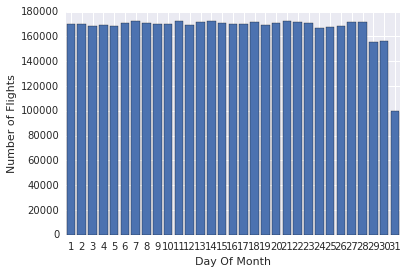

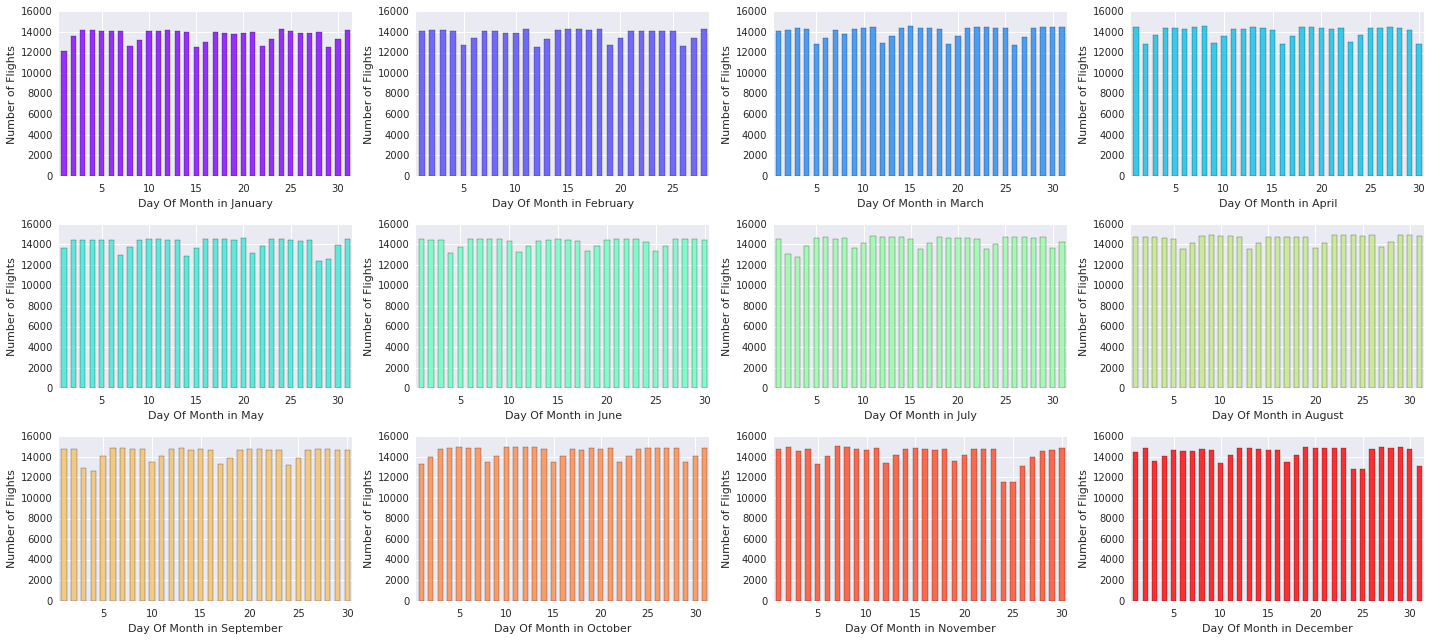

In [133]:
fl_per_dayOfMonth = df.groupBy('day_of_month').count().orderBy('day_of_month').select('count').collect()
plt.xlabel('Day Of Month')
plt.ylabel('Number of Flights')
plt.xlim(0.5, 31.5)
plt.xticks(range(1,32, 1))
plt.bar(range(1,32), np.array(fl_per_dayOfMonth), align='center')
plt.show()

# data to plot
import matplotlib.cm as cm
n_groups = 12

# create plot
plt.figure(figsize=(20, 9)) 
index = np.arange(0, n_groups * 5, 1)
bar_width = 0.55
opacity = 0.8 
colors = cm.rainbow(np.linspace(0, 1, 12))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fl_per_dayOfMonth_global = df.groupBy(['month', 'day_of_month']).count().orderBy(['month', 'day_of_month'])

for i in range(1, 13):
    days_data = np.array(fl_per_dayOfMonth_global[fl_per_dayOfMonth_global.month == i].select('count').collect())
    plt.subplot(3, 4, i)
    plt.xlabel('Day Of Month in ' + months[i-1])
    plt.ylabel('Number of Flights')
    plt.xlim(0.5, len(days_data)+0.5)
    plt.bar(range(1,len(days_data)+1, 1), days_data, align='center', width=bar_width, alpha=opacity, color=colors[i-1])
 
plt.tight_layout()
plt.show()

The number of flights has minor variations over the different days of the month. Anyway we can see how, for each festive day, there is always a decrease in the amount of flights. This behaviours can be observed for Christmas and Thanksgiving Day. On the other hand, in Summer months (June, July and August) we almost never see any decrement in the number of flights with respect to the days of the month.

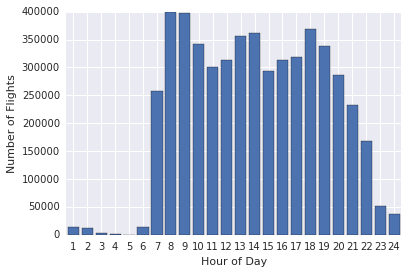

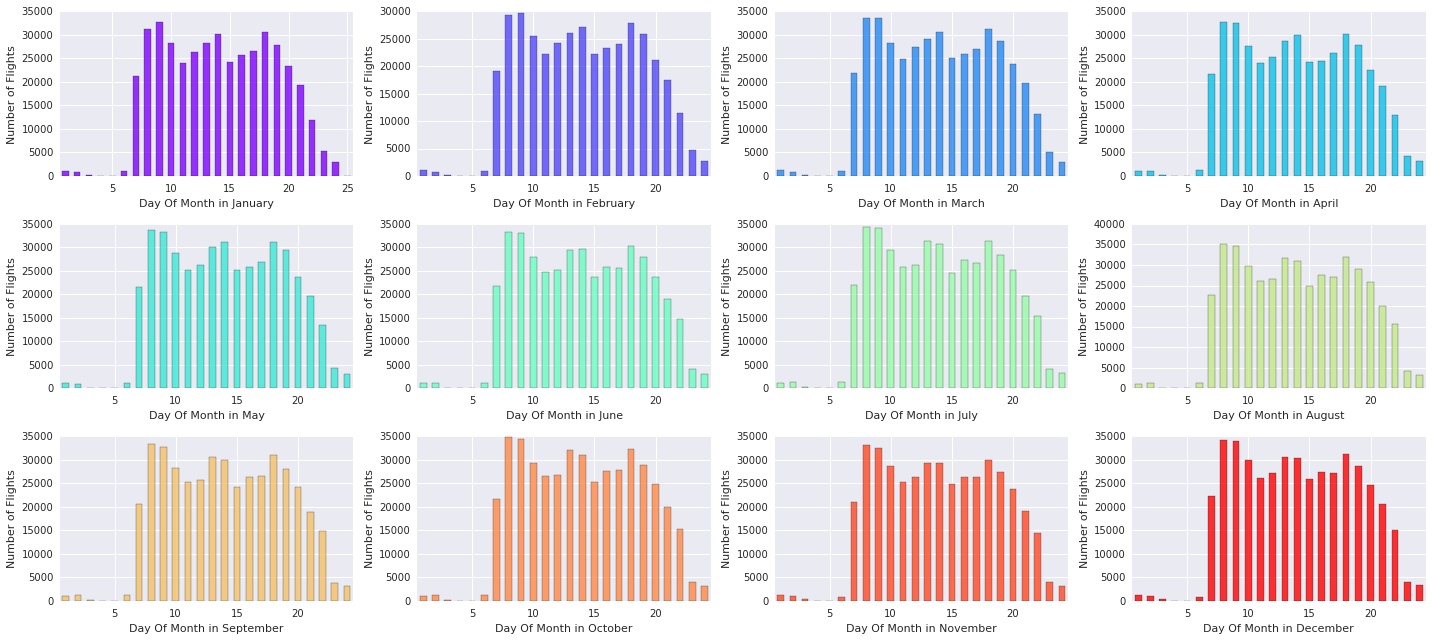

In [134]:
data_groupedByDepTime = df.withColumn("sched_dep_time_casted", (df.scheduled_departure_time/100).cast('int')).groupBy('sched_dep_time_casted')\
    .count().orderBy('sched_dep_time_casted').select('count').collect()
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.xticks(range(1,len(data_groupedByDepTime)+1, 1))
plt.xlim(0.5, 24.5)
plt.bar(range(1,26), np.array(data_groupedByDepTime), align='center')
plt.show()

# data to plot
import matplotlib.cm as cm
n_groups = 12

# create plot
plt.figure(figsize=(20, 9)) 
index = np.arange(0, n_groups * 5, 5)
bar_width = 0.55
opacity = 0.8 
colors = cm.rainbow(np.linspace(0, 1, 12))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data_groupedByDepTime_global = df.withColumn("sched_dep_time_casted", (df.scheduled_departure_time/100).cast('int')).groupBy(['month', 'sched_dep_time_casted'])\
    .count().orderBy(['month', 'sched_dep_time_casted'])

for i in range(1, 13):
    hours_data = np.array(data_groupedByDepTime_global[data_groupedByDepTime_global.month == i].select('count').collect())
    plt.subplot(3, 4, i)
    plt.xlabel('Day Of Month in ' + months[i-1])
    plt.ylabel('Number of Flights')
    plt.xlim(0.5, len(hours_data)+0.5)
    plt.bar(range(1,len(hours_data)+1), hours_data, align='center', width=bar_width, alpha=opacity, color=colors[i-1])
 
plt.tight_layout()
plt.show()

Our analysis was performed by using the departure time as our reference.

The hours of day with the higher number of flights are those included in the working hours. In fact we can see that most of the flights arrive between 8AM and 8PM, while there is a very low number of flights between 10PM and 6AM.

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [135]:
sorted_airports_in = df.groupBy('dest_airport').count().orderBy('count', ascending=False)\
    .withColumnRenamed("dest_airport", "airport")
sorted_airports_in.withColumnRenamed("count", "inbound_flights").show()

sorted_airports_out = df.groupBy('src_airport').count().orderBy('count', ascending=False)\
    .withColumnRenamed("src_airport", "airport")
sorted_airports_out.withColumnRenamed("count", "outbound_flights").show()

sorted_airports_tot = sorted_airports_in.union(sorted_airports_out)\
    .groupBy('airport').sum('count').orderBy('sum(count)', ascending=False)
sorted_airports_tot.withColumnRenamed("sum(count)", "total_flights").show()

+-------+---------------+
|airport|inbound_flights|
+-------+---------------+
|    ORD|         283720|
|    DFW|         260249|
|    ATL|         221588|
|    LAX|         152959|
|    STL|         152800|
|    DEN|         144099|
|    PHX|         140979|
|    DTW|         139435|
|    PIT|         131962|
|    CLT|         130321|
|    MSP|         124758|
|    SFO|         117245|
|    EWR|         117223|
|    IAH|         104409|
|    LGA|         101498|
|    BOS|          99331|
|    LAS|          94948|
|    PHL|          93312|
|    DCA|          87670|
|    MCO|          76600|
+-------+---------------+
only showing top 20 rows

+-------+----------------+
|airport|outbound_flights|
+-------+----------------+
|    ORD|          277741|
|    DFW|          256274|
|    ATL|          221486|
|    LAX|          153494|
|    STL|          151609|
|    DEN|          141427|
|    PHX|          139581|
|    DTW|          136837|
|    PIT|          130977|
|    CLT|          129391|

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [136]:
sorted_carriers = df.groupBy('carrier').count().orderBy('count', ascending=False)
sorted_carriers.withColumnRenamed("count", "number_of_flights").show()

+-------+-----------------+
|carrier|number_of_flights|
+-------+-----------------+
|     DL|           874526|
|     US|           857906|
|     AA|           722277|
|     UA|           638750|
|     WN|           565426|
|     CO|           484834|
|     NW|           482798|
|     TW|           258205|
|     HP|           177851|
|     AS|           117475|
+-------+-----------------+



## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

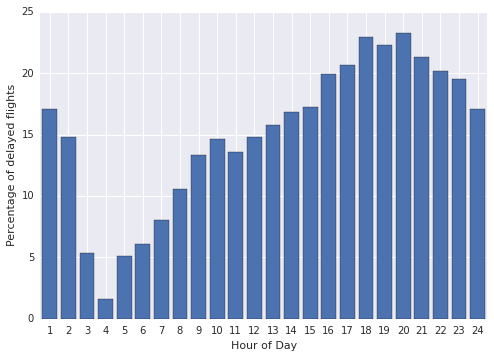

In [7]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
delay_ratio_per_hour = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy('hour')\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio')).orderBy('hour').select('delay_ratio').collect()
    
plt.xlabel('Hour of Day')
plt.ylabel('Percentage of delayed flights')
plt.xticks(range(1,len(delay_ratio_per_hour)+1, 1))
plt.xlim(0.5, 24.5)
plt.bar(range(1,26), np.array(delay_ratio_per_hour), align='center')
plt.show()

pdf_delay_ratio_per_hour = [list(range(0, 25)), np.array(delay_ratio_per_hour)]

Altough we did not explicitly show the plot, we observed that as most of the flights depart between 8AM and 8PM, most of them also arrive in the same time range. Assuming that the delay of a flight may influence the delay of other flights arriving to the same airport in a similar time range, the delay may be cumulative among flights. That would explain why the delay increases significantly starting from 7AM/8AM, reaching a spike at 8PM. In fact, after those rush hours, the percentage of delayed flights starts to decrease at 9PM, reaching their minimum value at 4AM, just two hours before the beginning of the next day's rush hours.

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

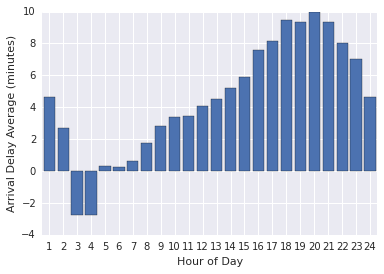

In [138]:
mean_delay_per_hour = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy('hour').avg('arrival_delay')\
    .orderBy('hour').select('avg(arrival_delay)').collect()
    
plt.xlabel('Hour of Day')
plt.ylabel('Arrival Delay Average (minutes)')
plt.xticks(range(1,len(mean_delay_per_hour)+1, 1))
plt.xlim(0.5, 24.5)
plt.bar(range(1,26), np.array(mean_delay_per_hour), align='center')
plt.show()

pdf_mean_delay_per_hour = [list(range(0, 25)), np.array(mean_delay_per_hour)]

From the above bar plot we can see how, starting from 8AM, the average delay starts to grow significantly until reaching a peak at 8PM, where it starts decreasing again. For 3AM and 4AM we can see that the average arrival delay has a negative value, meaning that the flight landed earlier. Those observations matches with what we said when answering question 4.1.

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

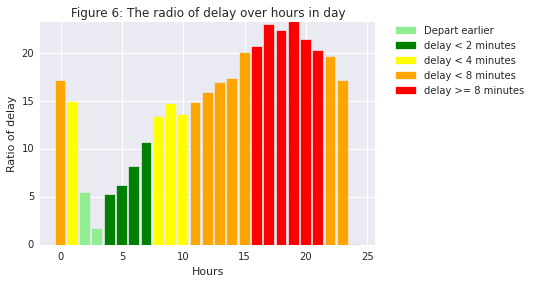

In [139]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

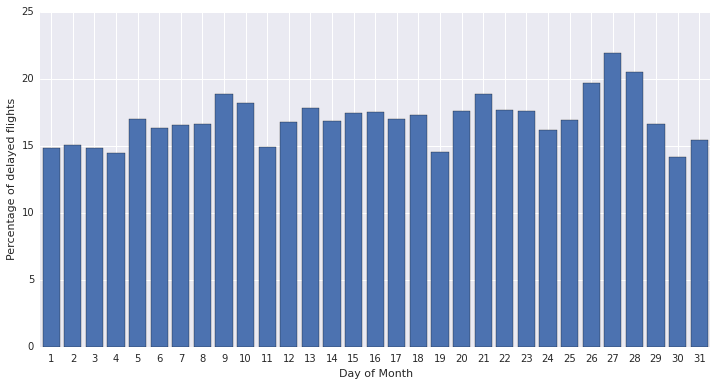

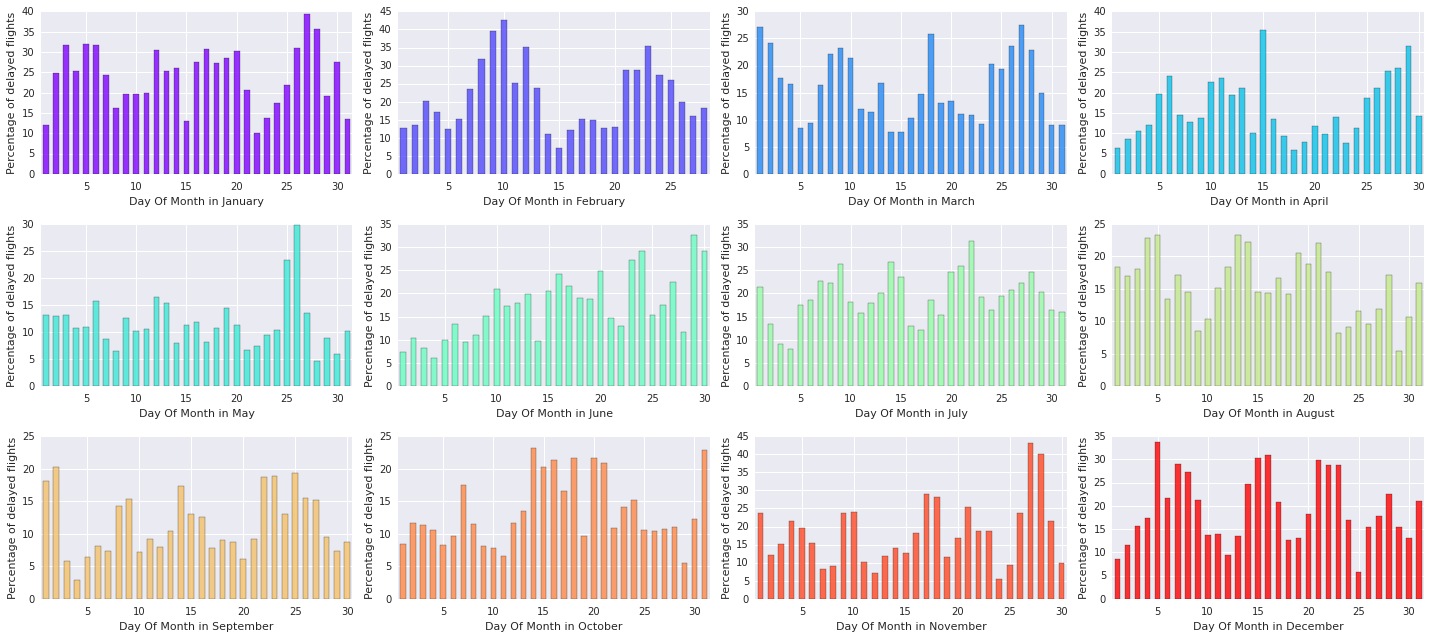

In [140]:
delay_ratio_per_dayOfMonth = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy('day_of_month')\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio')).orderBy('day_of_month').select('delay_ratio').collect()
    
plt.figure(figsize=(12, 6)) 
plt.xlabel('Day of Month')
plt.ylabel('Percentage of delayed flights')
plt.xticks(range(1,len(delay_ratio_per_dayOfMonth)+1, 1))
plt.xlim(0.5, len(delay_ratio_per_dayOfMonth)+0.5)
plt.bar(range(1,len(delay_ratio_per_dayOfMonth)+1), np.array(delay_ratio_per_dayOfMonth), align='center')
plt.show()

# data to plot
import matplotlib.cm as cm
n_groups = 12

# create plot
plt.figure(figsize=(20, 9)) 
index = np.arange(0, n_groups * 5, 5)
bar_width = 0.55
opacity = 0.8 
colors = cm.rainbow(np.linspace(0, 1, 12))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
delay_ratio_per_dayOfMonth_global = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy(['month', 'day_of_month'])\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio')).orderBy(['month', 'day_of_month'])

for i in range(1, 13):
    days_data = np.array(delay_ratio_per_dayOfMonth_global[delay_ratio_per_dayOfMonth_global.month == i].select('delay_ratio').collect())
    plt.subplot(3, 4, i)
    plt.xlabel('Day Of Month in ' + months[i-1])
    plt.ylabel('Percentage of delayed flights')
    plt.xlim(0.5, len(days_data)+0.5)
    plt.bar(range(1,len(days_data)+1), days_data, align='center', width=bar_width, alpha=opacity, color=colors[i-1])
 
plt.tight_layout()
plt.show()

The months that reach lower maximum values for the percentage of delayed flights are August, September and October. Among them, the one that has better values is September. Anyway, if we do not limit our analysis to months reaching lower maximum values, we can see that May is probably the best month in terms of percentage of delayed flights. In fact, apart for the 25th and the 26th of May, the other days of that month have values below the general average. Therefore the best months in terms of chances to have your flight delayed are May and September.

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

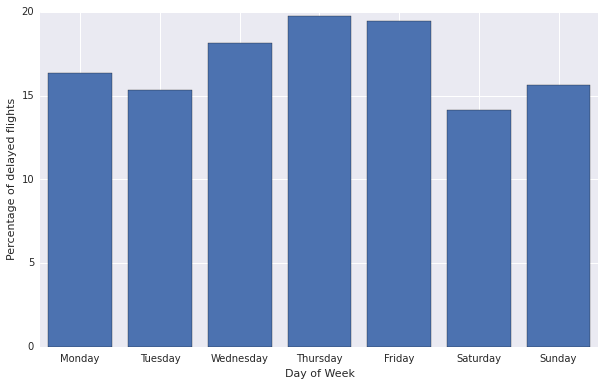

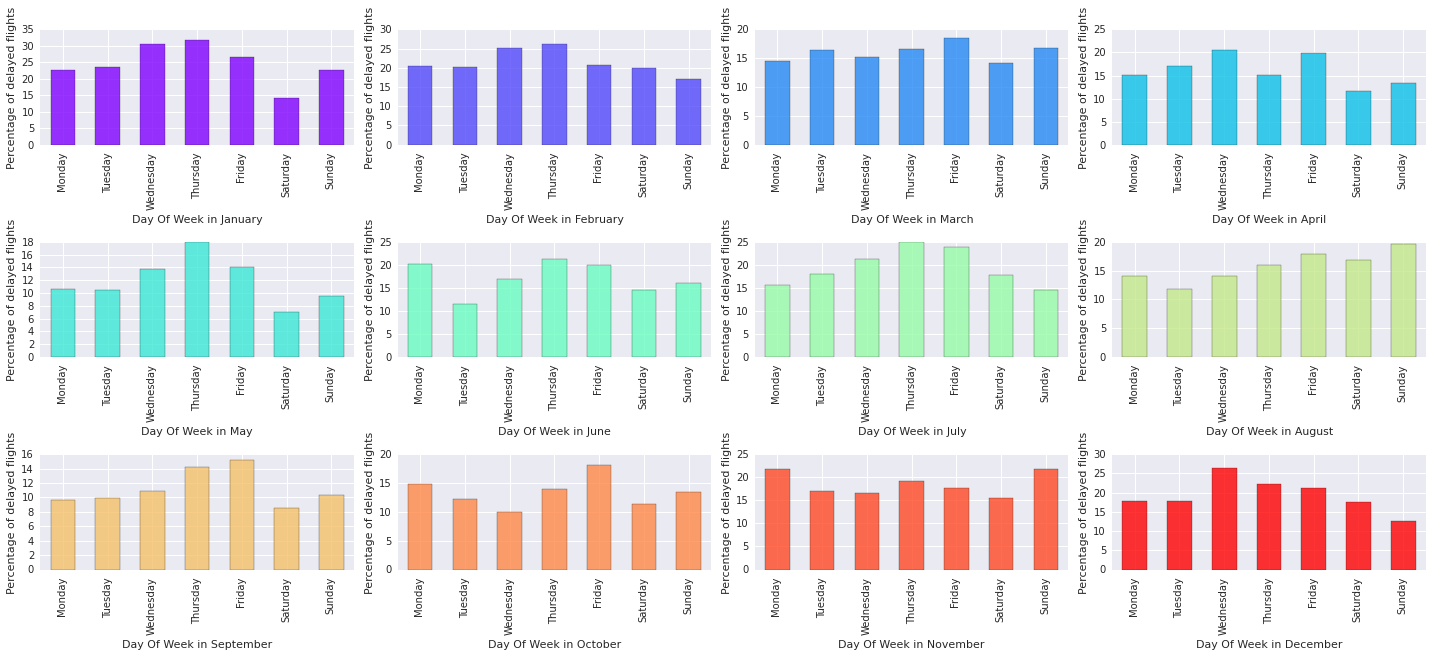

In [141]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

delay_ratio_per_dayOfWeek = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy('day_of_week')\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio')).orderBy('day_of_week').select('delay_ratio').collect()
    
plt.figure(figsize=(10, 6)) 
plt.xlabel('Day of Week')
plt.ylabel('Percentage of delayed flights')
plt.xticks(range(1,len(delay_ratio_per_dayOfWeek)+1, 1), days)
plt.xlim(0.5, len(delay_ratio_per_dayOfWeek)+0.5)
plt.bar(range(1,len(delay_ratio_per_dayOfWeek)+1), np.array(delay_ratio_per_dayOfWeek), align='center')
plt.show()

# data to plot
import matplotlib.cm as cm
n_groups = 12

# create plot
plt.figure(figsize=(20, 9)) 
index = np.arange(0, n_groups * 5, 5)
bar_width = 0.55
opacity = 0.8 
colors = cm.rainbow(np.linspace(0, 1, 12))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
delay_ratio_per_dayOfWeek_global = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy(['month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio')).orderBy(['month', 'day_of_week'])
    
for i in range(1, 13):
    days_data = np.array(delay_ratio_per_dayOfWeek_global[delay_ratio_per_dayOfWeek_global.month == i].select('delay_ratio').collect())
    plt.subplot(3, 4, i)
    plt.xlabel('Day Of Week in ' + months[i-1])
    plt.ylabel('Percentage of delayed flights')
    plt.xlim(0.5, len(days_data)+0.5)
    plt.bar(range(1,len(days_data)+1), days_data, align='center', width=bar_width, alpha=opacity, color=colors[i-1])
    plt.xticks(range(1,len(days_data)+1), days, rotation='vertical')

plt.tight_layout()
plt.show()

In most of the months we can see what is also shown in the first plot, which is the fact the three days in the middle of the week (Wednesday, Thursday and Friday) tend to have higher percentage of delayed flights with respect to Monday, Tuesday, Saturday and Sunday. This trend is present in almost all of the months of the year 1994.

Moreover the results shown above are also coherent with what we would expect from the comparison with the plot of percentage of delayed flights per month. In fact, as we have more delayed flights in January, the values of percentage of delayed flights per day of week in January is globally higher with respect to the values of other months. The same reasoning can be applied for the months of May and September, which have the lower value of percentage of delayed flights per month.

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

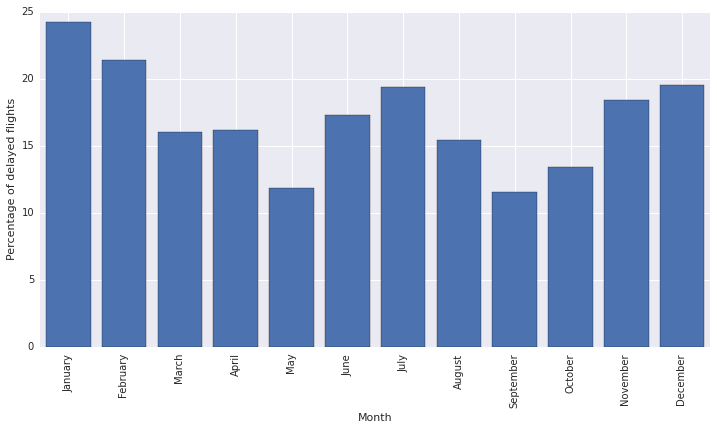

In [142]:
delay_ratio_per_monthOfYear = df_with_delay.withColumn("hour", (df.scheduled_departure_time/100).cast('int'))\
    .groupBy('month')\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio')).orderBy('month').select('delay_ratio').collect()

months = []
for month in range(1, 13):
    months.append(dt.datetime(year=1994, month=month, day=1).strftime("%B"))
    
plt.figure(figsize=(12, 6)) 
plt.xlabel('Month')
plt.ylabel('Percentage of delayed flights')
plt.xticks(range(1, 13), months, rotation='vertical')
plt.xlim(0.5, len(delay_ratio_per_monthOfYear)+0.5)
plt.bar(range(1,len(delay_ratio_per_monthOfYear)+1), np.array(delay_ratio_per_monthOfYear), align='center')
plt.show()

Coherently with all the analysis performed above, we have the lowest numbers of delayed flights in May and September, whereas in January we have the highest value. In general, the we have most of the delays in Winter months (January, February and December).This information may suggest that the delay of a flight may be correlated with weather conditions.

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [143]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

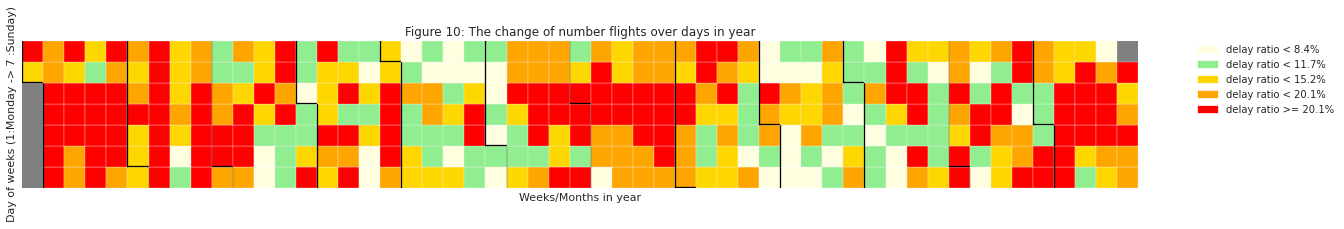

In [144]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

We believe that the general trend for France is the same except for the month of May. In fact France has several celebrations in the month of May that may affect the flight traffic.

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


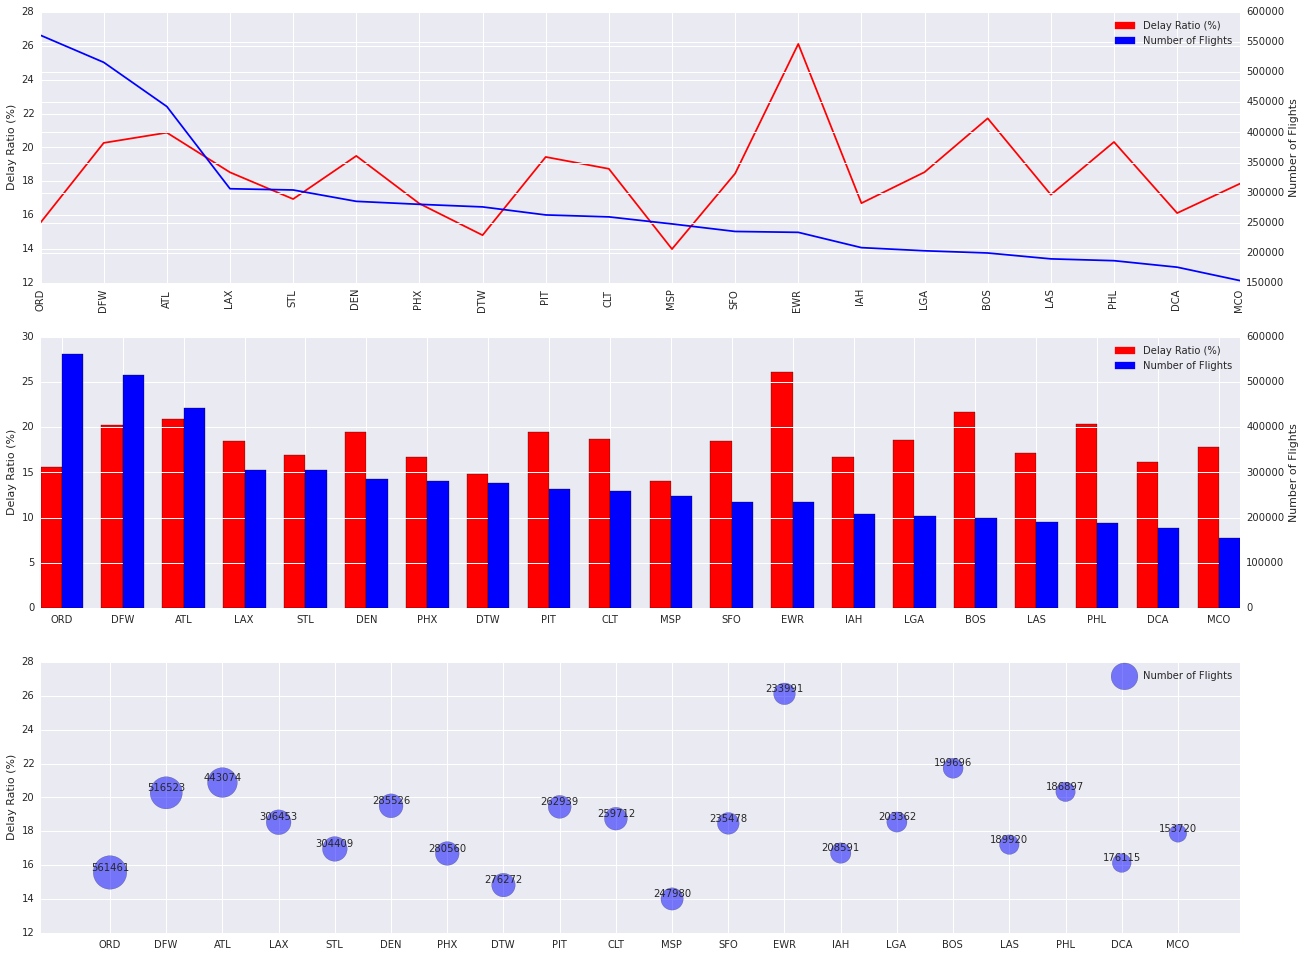

In [145]:
top_20_airports_df = sorted_airports_tot.limit(20).select('airport').collect()
top_20_airports = [r.airport for r in top_20_airports_df]

airports_delay_in = df_with_delay.filter(df_with_delay['src_airport'].isin(top_20_airports))
airports_delay_in = airports_delay_in.groupBy('src_airport')\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('src_airport', 'airport')
    
airports_delay_out = df_with_delay.filter(df_with_delay['dest_airport'].isin(top_20_airports))
airports_delay_out = airports_delay_out.groupBy('dest_airport')\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('dest_airport', 'airport')
    
airports_delay_tot = airports_delay_in.union(airports_delay_out)\
    .groupBy('airport')\
    .agg((func.sum('n_delays')/func.sum('n_flights')*100).alias('delay_ratio'),
        (func.sum('n_flights').alias('n_flights')))\
    .orderBy('n_flights', ascending=False)
airports_delay_tot_coll = airports_delay_tot.collect()
    
# Prepare data for plotting
x_values = range(len(top_20_airports))
y1 = [r.delay_ratio for r in airports_delay_tot_coll]
y2 = [r.n_flights for r in airports_delay_tot_coll]

# Create two subplots
fig, (ax11, ax21, ax3) = plt.subplots(3, 1, sharey=False)
fig.set_size_inches(21.5, 16.5)

# Line plot
ax12 = ax11.twinx()

ax11.set_xticks(x_values)
ax11.set_xticklabels(top_20_airports, rotation='vertical')

ax11.plot(x_values, y1, color='r')
ax11.set_ylabel('Delay Ratio (%)')

ax12.plot(x_values, y2, color='b')
ax12.set_ylabel('Number of Flights')

dr_patch = mpatches.Patch(color='r', label='Delay Ratio (%)')
nf_patch = mpatches.Patch(color='b', label='Number of Flights')
plt.legend(handles=[dr_patch,nf_patch])

# Bar Chart
ax22 = ax21.twinx()

ind = np.arange(len(x_values))
width = 0.35

ax21.set_xticks(ind + width)
ax21.set_xticklabels(top_20_airports)

ax21.bar(ind, y1, width, color='r')
ax21.set_ylabel('Delay Ratio (%)')

ax22.bar(ind + width, y2, width, color='b')
ax22.set_ylabel('Number of Flights')

dr_patch = mpatches.Patch(color='r', label='Delay Ratio (%)')
nf_patch = mpatches.Patch(color='b', label='Number of Flights')
plt.legend(handles=[dr_patch,nf_patch])

# Bubble Chart
ax3.set_ylabel('Delay Ratio (%)')
ax3.set_xticks(np.arange(len(x_values)))
ax3.set_xticklabels(top_20_airports)

sizes = np.zeros(len(y2))
for i in range(len(y2)):
    sizes[i] = y2[i] / 500
    ax3.annotate(y2[i], (i, y1[i]), ha='center', va='bottom')
scp = ax3.scatter(np.arange(len(x_values)), y1, s=sizes, c='b', label=y2, alpha=0.5)

ax3.legend(['Number of Flights'])

plt.show()

We used three different representation for our results. In the first one we plotted a line chart with two y axes where the first one is used for the display ratio value and the second one represents the number of flights. On the x axis we have the different airports. The second plot has a couple of bars for each airport, respectively representing the delay ratio and the number of flights. In the last plot we used a bubble representation where we have the airports on the x axis, the delay ratio on the y axis and the bubble size depends on the airport's number of flights.

Before analyzing the plots we produced, it is worth explaining a few assumptions we made throughout the computation of the airport's delay ratio. Since we are considering airports we assumed that, given an airport A, both the number of delayed flights departing from and arriving to A had to be considered. This is the reason why we firstly summed up the number of delayed flights with source airport equals to A, then we summed up the number of delayed flights with destination airport equals to A and finally we divided the sum of those values by the total number of flights to obtain the probability of delay in case airport A is involved (in any way) in a specific flight path.

From our plots we can see that at lower values of number of flights do not correspond lower values of delay ratio. Therefore we can conclude that there is no correlation between the size of the airport (where size is intented as number of flights served) and its delay ratio. This happens because the delay of a flight does not only depend on the number of flights served by the airport but it also depends on a set of variable factors e.g. number of customers, number of employees, weather conditions, etc.

In general the delay ratio is quite similar for all the airports except for EWR, which presents an above the average delay ratio value.

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


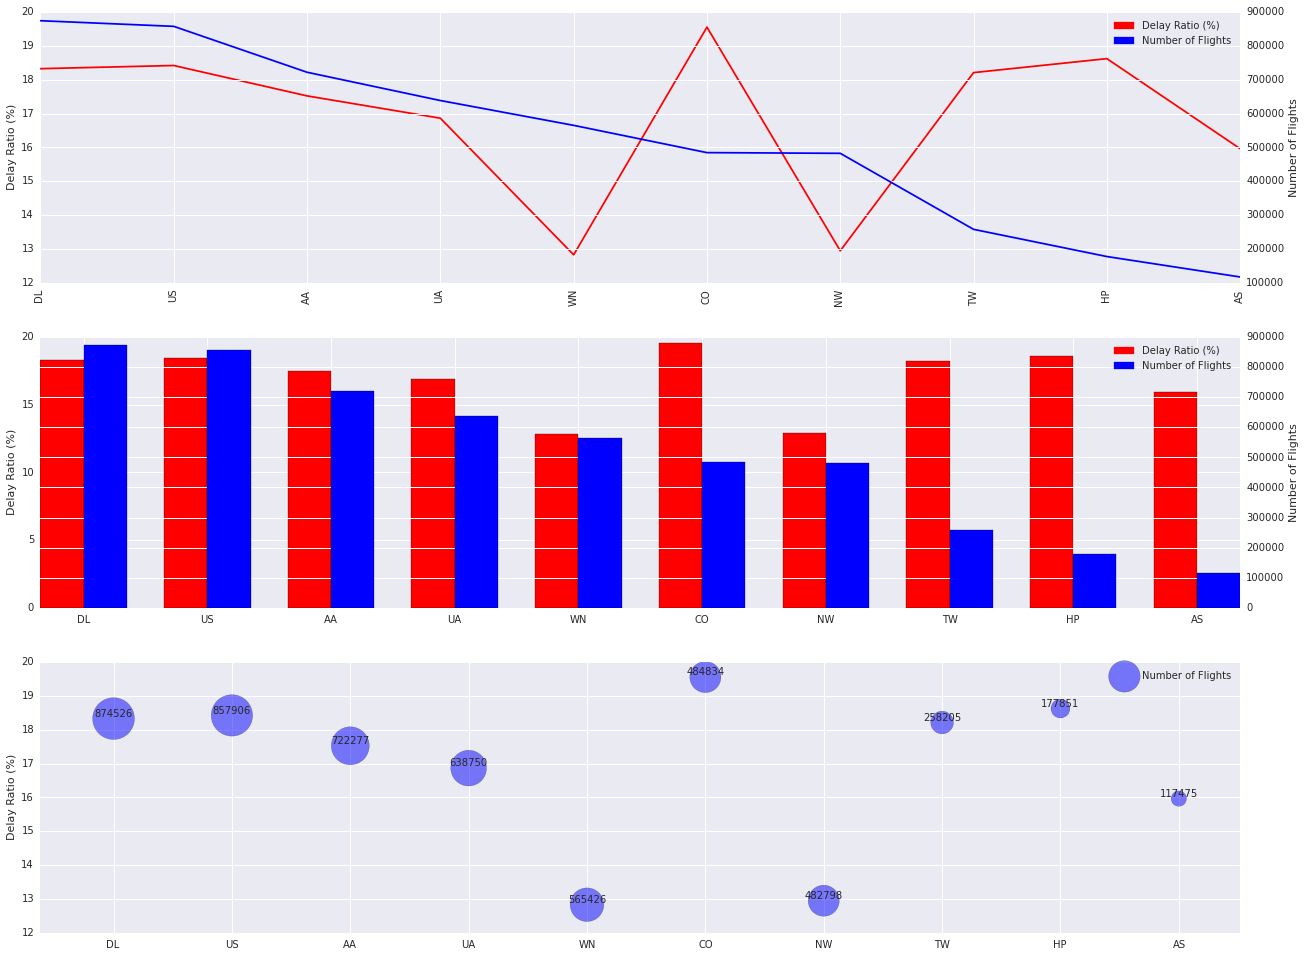

In [146]:
sorted_busy_carriers = df_with_delay.groupBy('carrier').count().orderBy('count', ascending=False)
top_20_carriers_df = sorted_busy_carriers.limit(20).select('carrier').collect()
top_20_carriers = [r.carrier for r in top_20_carriers_df]

carriers_delay = df_with_delay.filter(df_with_delay['carrier'].isin(top_20_carriers))
carriers_delay = carriers_delay.groupBy('carrier')\
    .agg((func.sum('is_delay')/func.count('*') * 100).alias('delay_ratio'),
        (func.count('*')).alias('n_flights'))\
    .orderBy('n_flights', ascending=False).collect()
    
# Prepare data for plotting
x_values = range(len(top_20_carriers))
y1 = [r.delay_ratio for r in carriers_delay]
y2 = [r.n_flights for r in carriers_delay]

# Create two subplots
fig, (ax11, ax21, ax3) = plt.subplots(3, 1, sharey=False)
fig.set_size_inches(21.5, 16.5)

# Line plot
ax12 = ax11.twinx()

ax11.set_xticks(x_values)
ax11.set_xticklabels(top_20_carriers, rotation='vertical')

ax11.plot(x_values, y1, color='r')
ax11.set_ylabel('Delay Ratio (%)')

ax12.plot(x_values, y2, color='b')
ax12.set_ylabel('Number of Flights')

dr_patch = mpatches.Patch(color='r', label='Delay Ratio (%)')
nf_patch = mpatches.Patch(color='b', label='Number of Flights')
plt.legend(handles=[dr_patch,nf_patch])

# Bar Chart
ax22 = ax21.twinx()

ind = np.arange(len(x_values))
width = 0.35

ax21.set_xticks(ind + width)
ax21.set_xticklabels(top_20_carriers)

ax21.bar(ind, y1, width, color='r')
ax21.set_ylabel('Delay Ratio (%)')

ax22.bar(ind + width, y2, width, color='b')
ax22.set_ylabel('Number of Flights')

dr_patch = mpatches.Patch(color='r', label='Delay Ratio (%)')
nf_patch = mpatches.Patch(color='b', label='Number of Flights')
plt.legend(handles=[dr_patch,nf_patch])

# Bubble Chart
ax3.set_ylabel('Delay Ratio (%)')
ax3.set_xticks(np.arange(len(x_values)))
ax3.set_xticklabels(top_20_carriers)

sizes = np.zeros(len(y2))
for i in range(len(y2)):
    sizes[i] = y2[i] / 500
    ax3.annotate(y2[i], (i, y1[i]), ha='center', va='bottom')
scp = ax3.scatter(np.arange(len(x_values)), y1, s=sizes, c='b', label=y2, alpha=0.5)

ax3.legend(['Number of Flights'])

plt.show()

We used three different representation for our results. In the first one we plotted a line chart with two y axes where the first one is used for the display ratio value and the second one represents the number of flights. On the x axis we have the different airports. The second plot has a couple of bars for each airport, respectively representing the delay ratio and the number of flights. In the last plot we used a bubble representation where we have the airports on the x axis, the delay ratio on the y axis and the bubble size depends on the airport's number of flights.

Before analyzing the plots we produced, it is worth explaining a few assumptions we made throughout the computation of the airport's delay ratio. Since we are considering airports we assumed that, given an airport A, both the number of delayed flights departing from and arriving to A had to be considered. This is the reason why we firstly summed up the number of delayed flights with source airport equals to A, then we summed up the number of delayed flights with destination airport equals to A and finally we divided the sum of those values by the total number of flights to obtain the probability of delay in case airport A is involved (in any way) in a specific flight path.

From our plots we can see that at lower values of number of flights do not correspond lower values of delay ratio. Therefore we can conclude that there is no correlation between the size of the airport (where size is intented as number of flights served) and its delay ratio. This happens because the delay of a flight does not only depend on the number of flights served by the airport but it also depends on a set of variable factors e.g. number of customers, number of employees, weather conditions, etc.

In general the delay ratio is quite similar for all the airports except for EWR, which presents an above the average delay ratio value.

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>


Before answering questions 5.1 and 5.2 we built a data frame aggregating information from the whole dataset, not only with those for year 1994.

In [11]:
df_complete = sqlContext.read.load('/datasets/airline/*.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

# Answer 5.1

In [12]:
origin_col = df_complete.select('Origin')
dest_col = df_complete.select('Dest')

# Compute airport present only as destination
src_only = origin_col.subtract(dest_col).withColumnRenamed('Origin', 'airport')
print('Airports present in the dataset only as destination airport:')
src_only.show()

# Compute airport present only as source
dest_only = dest_col.subtract(origin_col).withColumnRenamed('Dest', 'airport')
print('Airports present in the dataset only as source airport:')
dest_only.show()

Airports present in the dataset only as destination airport:
+-------+
|airport|
+-------+
+-------+

Airports present in the dataset only as source airport:
+-------+
|airport|
+-------+
|    RCA|
|    LBF|
|    MKC|
|    LAR|
|    CBM|
|    SKA|
+-------+



# Answer 5.2

In [13]:
# Compute delay for any row of the dataset
df_complete_with_delay = df_complete.withColumn('is_delay', func.when(df_complete["ArrDelay"] >= 15, 1).otherwise(0))

In [14]:
# Compute delay ratio for all airports
airports_delay_in = df_complete_with_delay.groupBy('Origin')\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('Origin', 'airport')
    
airports_delay_out = df_complete_with_delay.groupBy('Dest')\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('Dest', 'airport')
    
airports_delay_ratio_tot = airports_delay_in.union(airports_delay_out)\
    .groupBy('airport')\
    .agg((func.sum('n_delays')/func.sum('n_flights')*100).alias('delay_ratio'),
        (func.sum('n_flights').alias('n_flights')))\
    .orderBy('delay_ratio', ascending=False)\
    .select(['airport', 'delay_ratio'])
    
print('Airports with biggest delay ratio')
airports_delay_ratio_tot.show()

Airports with biggest delay ratio
+-------+------------------+
|airport|       delay_ratio|
+-------+------------------+
|    BFI|              50.0|
|    BFF|              50.0|
|    OTH|41.957364341085274|
|    FMN|              37.5|
|    ILG| 36.64335664335665|
|    ACK| 35.21970705725699|
|    ADK|32.818930041152264|
|    SOP| 32.25806451612903|
|    LMT|28.785211267605632|
|    CKB| 28.57142857142857|
|    PIR| 27.27272727272727|
|    EGE|26.588258212189835|
|    MQT|25.849398231973588|
|    EWR|25.804383629130495|
|    JFK|25.702476865380667|
|    DHN| 25.67945419975394|
|    MCN|25.605926403092038|
|    PSG|25.172353455818026|
|    HHH|25.059808612440193|
|    OGD|              25.0|
+-------+------------------+
only showing top 20 rows



For the second part of this answer it was used the dataset linked at [http://stat-computing.org/dataexpo/2009/carriers.csv](http://stat-computing.org/dataexpo/2009/carriers.csv). This dataset was joined with the data frame containing flights data, to which it was added the information regarding the number of delayed flights. 

In [15]:
# Read cities dataframe
cities_df = sqlContext.read.load('airports.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

In [16]:
# Compute the average delay duration per airport
airports_delay_in = df_complete.groupBy('Origin')\
    .agg((func.sum('DepDelay')).alias('delay'),\
        (func.count('*')).alias('n_flights'))\
    .withColumnRenamed('Origin', 'airport')
    
airports_delay_out = df_complete.groupBy('Dest')\
    .agg((func.sum('ArrDelay')).alias('delay'),\
        (func.count('*')).alias('n_flights'))\
    .withColumnRenamed('Dest', 'airport')
    
airports_delay_tot = airports_delay_in.union(airports_delay_out)\
    .groupBy('airport')\
    .agg((func.sum('delay')/func.sum('n_flights')).alias('delay'))\

# Join flights data frame with cities dataframe
cities_df = cities_df.select(['iata', 'city', 'state'])
complete_df = airports_delay_tot.join(cities_df, cities_df.iata == airports_delay_tot.airport)

# Compute average delay duration per city
result = complete_df.groupBy(['state', 'city'])\
    .agg((func.avg('delay').alias('delay')))\
    .orderBy('delay', ascending=False)\
    .select(['state', 'city', 'delay'])
print('Cities with largest delay duration in average')
result.show()

Cities with largest delay duration in average
+-----+--------------------+------------------+
|state|                city|             delay|
+-----+--------------------+------------------+
|   NM|          Farmington|            76.375|
|   NE|         Scottsbluff|              65.5|
|   UT|               Ogden|              43.1|
|   WY|            Cheyenne|             36.25|
|   OR|          North Bend|23.401162790697676|
|   SD|              Pierre|20.727272727272727|
|   MA|           Nantucket| 19.81491344873502|
|   WV|          Clarksburg|              18.0|
|   OR|       Klamath Falls|17.099471830985916|
|   AK|                Adak|16.301440329218106|
|   DE|          Wilmington|14.632167832167832|
|   IL|         Springfield| 12.80273159144893|
|   GA|               Macon| 12.47040824543039|
|   AK|          Petersburg|12.199510061242345|
|   CO|               Eagle| 12.00637981834563|
|   AL|              Dothan|11.312884464824963|
|   IL|         Bloomington|11.18271670190

# Answer 5.3

For answering this question we preparend a dataset containing a record for each day of the year 1994 having the following schema: 

`| airport | mean_temperature | mean_precipitation | mean_windspeed | month | day | year |`

It is also worth mentioning that, since obtaining huge amount of data from the `wundergroud` API was quite difficult using a non-paid API key, we restricted our analysis only to some of the airports with the largest amount of traffic. In particular we analyzed the airports identified by the following codes: `DEN`, `CLT`, `PHX`, `STL`, `DFW`, `ATL` and `ORD`. Those airports were all belong to the top 20 busiest airports as noted in answer to Question 3.4.

This dataset was stored in HDFS in the `weather-dataset.csv` file and then loaded into a data frame.

In [9]:
# Read weather dataset
weather_df = sqlContext.read.load('weather-dataset.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

In [10]:
# Build a data frame containing delay ratio for the analyzed airports
an_airports = ['DEN', 'CLT', 'PHX', 'STL', 'DFW', 'ATL', 'ORD']

# Here we used the data frame df_with_delay produce in the answer to question 4.1
airports_delay_in = df_with_delay.filter(df_with_delay['src_airport'].isin(an_airports))
airports_delay_in = airports_delay_in.groupBy(['src_airport', 'month'])\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('src_airport', 'airport')
    
airports_delay_out = df_with_delay.filter(df_with_delay['dest_airport'].isin(an_airports))
airports_delay_out = airports_delay_out.groupBy(['dest_airport', 'month'])\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('dest_airport', 'airport')
    
airports_delay_tot = airports_delay_in.union(airports_delay_out)\
    .groupBy(['airport', 'month'])\
    .agg((func.sum('n_delays')/func.sum('n_flights')*100).alias('delay_ratio'),
        (func.sum('n_flights').alias('n_flights')))\
    .orderBy(['airport', 'month'])\
    .drop('n_flights')

In [11]:
# Produce a datafrane with airport, delay_ratio, meantempm, precipm, meanwindspdm, month and day
delay_weather_df = airports_delay_tot.join(weather_df, (weather_df.city == airports_delay_tot.airport) 
                                           & (weather_df.month == airports_delay_tot.month))\
    .drop(weather_df.city).drop(airports_delay_tot.month)

In [12]:
# Total airport's delay ration is stored in airports_delay_ratio_tot
result = delay_weather_df.groupBy(['airport', 'month', 'delay_ratio'])\
    .agg(
        (func.avg('meantempm')).alias('temp'),
        (func.avg('meanwindspdm')).alias('wind'),
        (func.sum('precipm')).alias('precip'))\
    .orderBy(['airport', 'month'], ascending=True)

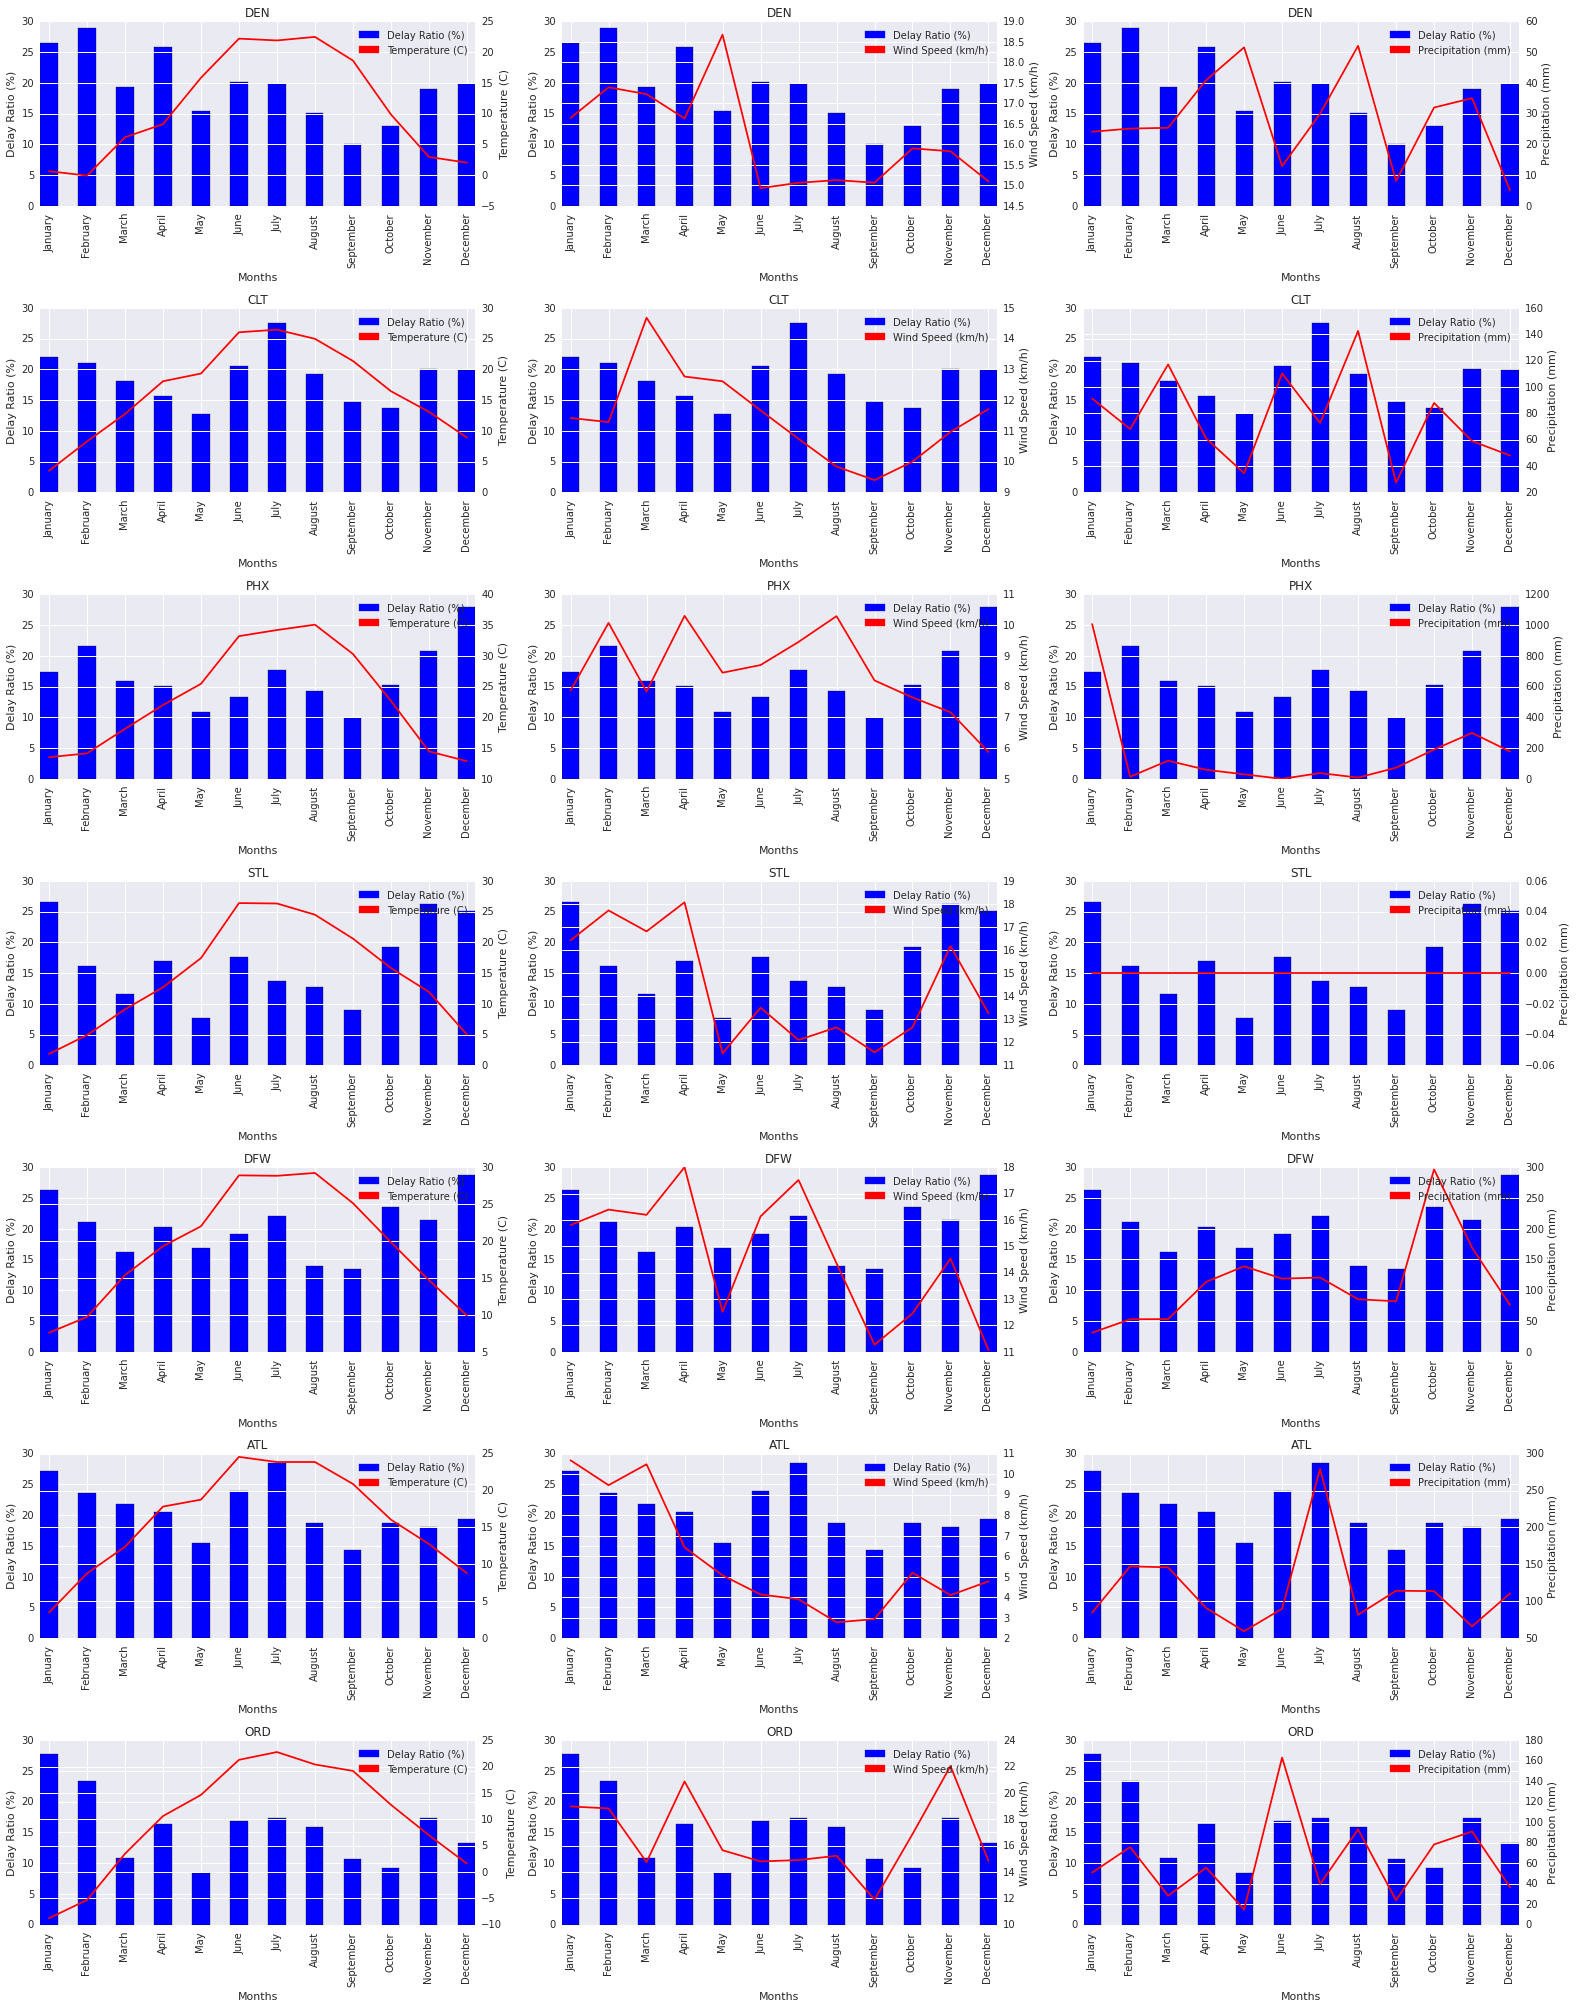

In [13]:
import matplotlib.cm as cm

# Plot data

n_groups = 21

# create plot
plt.figure(figsize=(22, 28)) 
index = np.arange(0, n_groups * 5, 5)
bar_width = 0.55
opacity = 0.8 
colors = cm.rainbow(np.linspace(0, 1, 12))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
airports = [r.airport for r in result.select('airport').distinct().collect()]

# Utility function for avoid some code duplication
plot_idx = 0
def createPlot(title, dr, temp, wind, precip):
    global plot_idx
    
    ylabels = ['Temperature (C)', 'Wind Speed (km/h)', 'Precipitation (mm)']
    
    data = [ temp, wind, precip ]
    
    for i in range(3):
        plot_idx += 1
        ax1 = plt.subplot(7, 3, plot_idx)
        ax1.set_title(title)
        plt.xlabel('Months')
       
        ax2 = ax1.twinx()
    
        ax1.set_ylabel('Delay Ratio (%)')
        ax1.set_xticks(range(12))
        ax1.set_xticklabels(months, rotation='vertical')
        ax1.bar(np.arange(12), dr, 0.45, color='b', align='center')
    
        ax2.set_ylabel(ylabels[i])
        ax2.set_xticks(range(12))
        ax2.set_xticklabels(months, rotation='vertical')
        ax2.plot(range(12), data[i], 'r')
        
        dr_patch = mpatches.Patch(color='b', label='Delay Ratio (%)')
        nf_patch = mpatches.Patch(color='r', label=ylabels[i])
        plt.legend(handles=[dr_patch,nf_patch])

for airport in airports:
    # Query data to be plotted
    temp_df = result.where(result.airport == airport).orderBy('month', ascending=True)
    dr = [x.delay_ratio for x in temp_df.select('delay_ratio').collect()]
    temp = [x.temp for x in temp_df.select('temp').collect()]
    wind = [x.wind for x in temp_df.select('wind').collect()]
    precip = [x.precip for x in temp_df.select('precip').collect()]
    
    # Plot delay_ration against temperature
    createPlot(airport, dr, temp, wind, precip)

plt.tight_layout()
plt.show()

In the plots above we have represented the relations among the average delay ratio per month and the three weather parameters we examined: temperature, expressed in Celsius degrees; wind speed, expressed in km/h; precipitation, expressed in millimeters. We have produced a plot for each airport and each weather parameter. Each value of temperature and wind speed is a monthly average while the precipitation values are cumulative monthly sums.

From the resulting plots it is possible to notice that only in some cases there is a correlation between the delay ratio and the particular weather conditions we analyzed. For instance, for the airport with the code `ATL`, we can see that in July the precipitation amount is higher than the average value and coherently the delay ratio is higher than its average value. Something similar happens also in the month of October for the airport `DFW`.

Regarding wind speed, instead, our weather dataset shows that we never have highly windy conditions throughout year 1994. This anomaly in data may be due to the fact that we computed used a monthly averaged value. If we had computed the statistics day by day we could have noticed a correlation between wind speed and delay ratio but this is not visible in the above plots. This assumption is valid since it is possible to have high values for the wind speed only in some days of the month, whereas in the other ones, it may assume much lower values causing the monthly average to be small. Wind speed is further analyzed in the next sections of the notebook.

As we were expecting there is no direct correlation between the average temperature and the delay ratio.

It is also worth mentioning the fact that our dataset presents some outliers. For example, for the airport `PHX` we noticed that the Wunderground API returns a precipitation value of 777.24 mm for the 28th January. This value appears to be irrealistic if compared with real world statistics and this is the cause of the anomaly in the `PHX` plot for precipitations.

To provide a better understanding of how the precipitations and the wind speed affect flights delays we moved on a daily basis analysis, considering the pair airport-month with the highest monthly average wind speed and the pair airport-month with the highest monthly precipitation value.

We first started analyzing precipitations. Below are shown the pairs airport-month sorted by monthly precipitation amount. In order to eliminate outliers we decided to consider only those data for which the amount of monthly precipitation is below 150mm. We assumed this value to be close to the maximum possible realistic amount of monthly precipitation in a city of the United States.

In [14]:
print('Pairs airport-month with the highest monthly precipitation amount:')
result.filter(result.precip <= 150).orderBy('precip', ascending=False).select(['airport', 'month', 'precip']).show()

Pairs airport-month with the highest monthly precipitation amount:
+-------+-----+------------------+
|airport|month|            precip|
+-------+-----+------------------+
|    ATL|    2|            147.33|
|    ATL|    3|146.06000000000003|
|    CLT|    8|142.48999999999998|
|    DFW|    5|            138.94|
|    DFW|    7|            120.65|
|    DFW|    6|118.86999999999999|
|    PHX|    3|118.10000000000002|
|    CLT|    3|117.10000000000001|
|    ATL|    9|114.29000000000003|
|    ATL|   10|113.80999999999999|
|    DFW|    4|            113.54|
|    ATL|   12|110.75000000000001|
|    CLT|    6|110.24000000000001|
|    ORD|    8|             92.97|
|    CLT|    1| 91.19000000000001|
|    ATL|    4|             90.93|
|    ORD|   11| 90.92000000000002|
|    ATL|    6|             89.93|
|    CLT|   10|             87.89|
|    DFW|    8| 85.35000000000001|
+-------+-----+------------------+
only showing top 20 rows



In order to provide a better understanding of the correlation between precipitation and delay ratio we moved our focus on the month of Febraury for the airport `ATL`.

In [15]:
# Build a delay data frame containining daily information only for the analyzed airports
an_airports = ['DEN', 'CLT', 'PHX', 'STL', 'DFW', 'ATL', 'ORD']

airports_daily_delay_in = df_with_delay.filter(df_with_delay['src_airport'].isin(an_airports))
airports_daily_delay_in = airports_daily_delay_in.groupBy(['src_airport', 'month', 'day_of_month'])\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('src_airport', 'airport')
    
airports_daily_delay_out = df_with_delay.filter(df_with_delay['dest_airport'].isin(an_airports))
airports_daily_delay_out = airports_daily_delay_out.groupBy(['dest_airport', 'month', 'day_of_month'])\
    .agg((func.sum('is_delay')).alias('n_delays'), 
         (func.count('*').alias('n_flights')))\
    .withColumnRenamed('dest_airport', 'airport')
    
airports_daily_delay_tot = airports_daily_delay_in.union(airports_daily_delay_out)\
    .groupBy(['airport', 'month', 'day_of_month'])\
    .agg((func.sum('n_delays')/func.sum('n_flights')*100).alias('delay_ratio'))\
    .orderBy(['airport', 'month', 'day_of_month'])\
    .drop('n_flights')

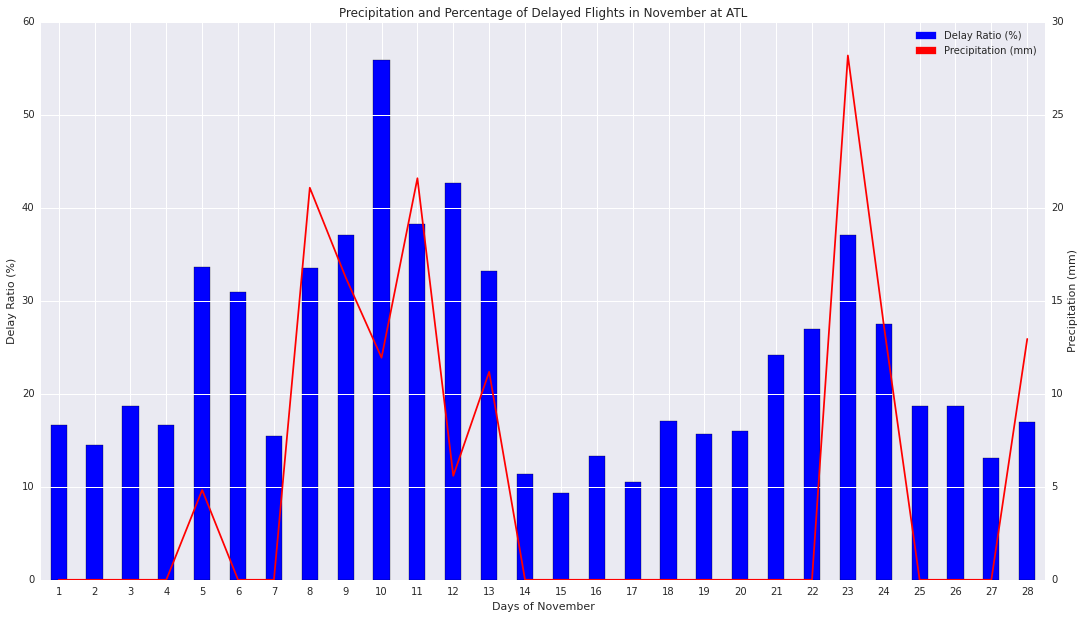

In [16]:
# Query delay ratio data for ORD in month 11
dr_df = airports_daily_delay_tot.where((airports_daily_delay_tot.airport == 'ATL') 
                                       & (airports_daily_delay_tot.month == 2))\
    .select('delay_ratio').collect()
wind_df = delay_weather_df.where((delay_weather_df.airport == 'ATL') & (delay_weather_df.month == 2))\
    .select(['day', 'precipm'])\
    .orderBy('day')\
    .collect()

wind = [r.precipm for r in wind_df]
dr = [r.delay_ratio for r in dr_df]
    
# Plot obtained data
plt.figure(figsize=(18, 10)) 
plt.xticks(np.arange(1, len(dr)+1), np.arange(1, len(dr)+1))

ax1 = plt.gca()
ax1.set_title('Precipitation and Percentage of Delayed Flights in November at ATL')
plt.xlabel('Days of November')
       
ax2 = ax1.twinx()
    
ax1.set_ylabel('Delay Ratio (%)')
ax1.set_xlim(1-0.5, len(dr)+0.5)
ax1.bar(np.arange(1, len(dr)+1), dr, 0.45, color='b', align='center')
    
ax2.set_ylabel('Precipitation (mm)')
ax2.plot(np.arange(1, len(wind)+1), wind, 'r')
        
dr_patch = mpatches.Patch(color='b', label='Delay Ratio (%)')
nf_patch = mpatches.Patch(color='r', label='Precipitation (mm)')
plt.legend(handles=[dr_patch,nf_patch])

As we can see, for the month of Febraury at airport `ATL` we can see that days with high precipitation (the 8th, the 11th the 23th) corresponds to high delay ratio values. Anyway there are also other days having high delay ratio values but low precipitations. This observation still matches with the previous one since delay is not only releated to precipitations.

The same type of analysis was performed for average wind speed.

Below are shown the pairs airport-month with the higher value of monthly average wind speed.

In [17]:
print('Most windy pairs airport-month:')
result.orderBy('wind', ascending=False).select(['airport', 'month', 'wind']).show()

Most windy pairs airport-month:
+-------+-----+------------------+
|airport|month|              wind|
+-------+-----+------------------+
|    ORD|   11|22.033333333333335|
|    ORD|    4|20.866666666666667|
|    ORD|    1|18.967741935483872|
|    ORD|    2|18.821428571428573|
|    DEN|    5|18.677419354838708|
|    STL|    4|18.066666666666666|
|    DFW|    4|              18.0|
|    STL|    2|17.714285714285715|
|    DFW|    7|17.516129032258064|
|    DEN|    2|17.392857142857142|
|    DEN|    3|17.225806451612904|
|    ORD|   10|16.870967741935484|
|    STL|    3|16.806451612903224|
|    DEN|    1| 16.64516129032258|
|    DEN|    4|16.633333333333333|
|    STL|    1|16.419354838709676|
|    DFW|    2|16.392857142857142|
|    DFW|    3|16.193548387096776|
|    STL|   11|16.166666666666668|
|    DFW|    6|16.133333333333333|
+-------+-----+------------------+
only showing top 20 rows



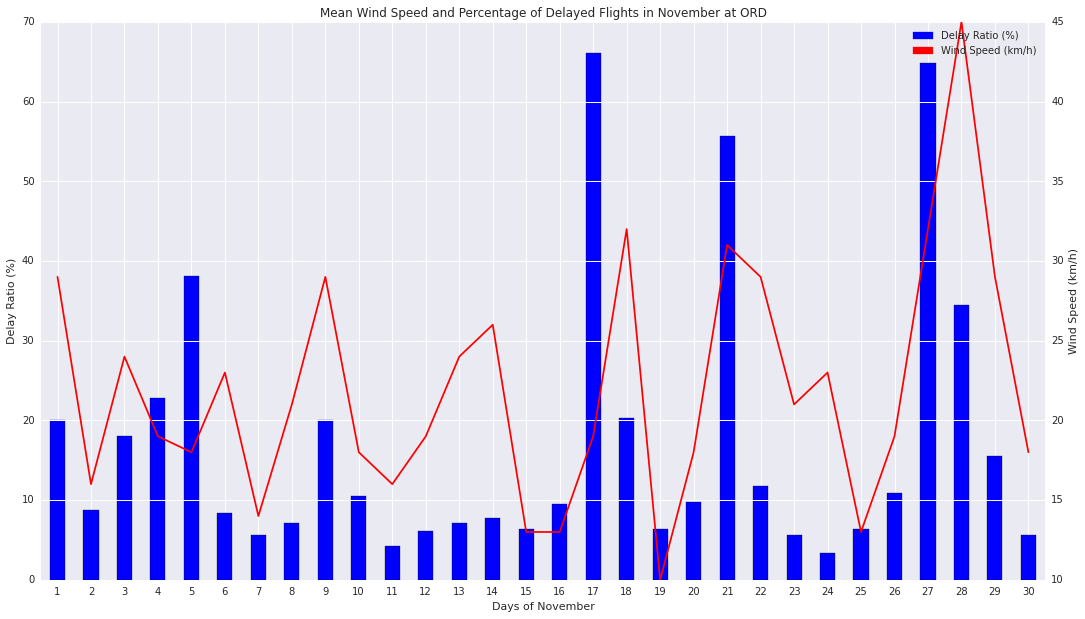

In [18]:
# Query delay ratio data for ORD in month 11
dr_df = airports_daily_delay_tot.where((airports_daily_delay_tot.airport == 'ORD') 
                                       & (airports_daily_delay_tot.month == 11))\
    .select('delay_ratio').collect()
prec_df = delay_weather_df.where((delay_weather_df.airport == 'ORD') & (delay_weather_df.month == 11))\
    .select(['day', 'meanwindspdm'])\
    .orderBy('day')\
    .collect()

prec = [r.meanwindspdm for r in prec_df]
dr = [r.delay_ratio for r in dr_df]
        
# Plot obtained data
plt.figure(figsize=(18, 10)) 
plt.xticks(np.arange(1, len(dr)+1), np.arange(1, len(dr)+1))

ax1 = plt.gca()
ax1.set_title('Mean Wind Speed and Percentage of Delayed Flights in November at ORD')
plt.xlabel('Days of November')
       
ax2 = ax1.twinx()
    
ax1.set_ylabel('Delay Ratio (%)')
ax1.set_xlim(1-0.5, len(dr)+0.5)
ax1.bar(np.arange(1, len(dr)+1), dr, 0.45, color='b', align='center')

ax2.set_ylabel('Wind Speed (km/h)')
ax2.plot(np.arange(1, len(prec)+1), prec, 'r')
        
dr_patch = mpatches.Patch(color='b', label='Delay Ratio (%)')
nf_patch = mpatches.Patch(color='r', label='Wind Speed (km/h)')
plt.legend(handles=[dr_patch,nf_patch])

In this case we can not appreciate any strict relationship between wind speed and delay ratio. This lack of information may be due to the fact that we never have very high values of wind speed. In fact wind is considered to be high speed only in case its value is greater than 50 km/h.

In our opinion, for providing a better understanding of the relationship between wind speed and delay ratio we may need some more detailed data. In fact, data obtained through the Wunderground API considered all city to which the airport belong to. If we had wind information only about the airport's area we would have seen some stricter correlation in our plot. Moreover, having data with higher time granularity would have halped as well e.g. one wind speed measurement per hour (or minute) of day.